# Classとは

### memo

In [1]:
# import datetime
# datetime.date(2011, 7, 24)

- データ型専用の関数の名前を覚える手間が少し省けて便利
- ポリモーフィズム

In [2]:
# __slots__ = ('r','j')
# メモリが節約され少し早くなる

In [3]:
# namedtuple()
# 変更不能なインスタンスを持つクラスと同じ

- is a関係の時にクラスを使うと便利
- forの3重ループ...などを避けられる

# 第5章: 係り受け解析

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

In [4]:
# !cabocha -f1 data/neko.txt > data/neko.txt.cabocha

In [5]:
infile_path = "data/neko.txt.cabocha"

In [6]:
!head $infile_path
!echo '.\n.\n.\n'
!tail $infile_path

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
.
.
.

南無阿弥陀仏	名詞,一般,*,*,*,*,南無阿弥陀仏,ナムアミダブツ,ナムアミダブツ
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 1D 0/0 0.000000
ありがたい	形容詞,自立,*,*,形容詞・アウオ段,基本形,ありがたい,アリガタイ,アリガタイ
* 1 -1D 0/0 0.000000
ありがたい	形容詞,自立,*,*,形容詞・アウオ段,基本形,ありがたい,アリガタイ,アリガタイ
。	記号,句点,*,*,*,*,。,。,。
EOS
EOS


# 40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

## Class : Morph

In [7]:
class Morph:
    """形態素のクラス。 表層形、基本形、品詞、品詞細分類1をメンバに持つ。"""
    __slots__ = ('surface','base','pos','pos1')
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1        
    def __str__(self):
        return f'{self.surface}'
    def __repr__(self):
        return f'Morph <surface:{self.surface} base:{self.base} pos:{self.pos} pos1:{self.pos1}>'

In [8]:
Morph?

Init signature: Morph(surface, base, pos, pos1)
Docstring:      形態素のクラス。 表層形、基本形、品詞、品詞細分類1をメンバに持つ。
Type:           type


#### CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現

In [9]:
import itertools
from pprint import pprint

In [10]:
def get_morph(line):
    val = line.replace('\t',',',1).split(',')
    return Morph(val[0],val[-3],val[1],val[2])

def get_morph_list(group):
    return [get_morph(line) for line in group if not line.startswith('* ')]

def read_morph_cabocha(file):
    for value,group in itertools.groupby(file,key=lambda line: line!='EOS\n'):
        if value: yield get_morph_list(group)

In [11]:
with open(infile_path) as f:
    for ls in itertools.islice(read_morph_cabocha(f),2,3):
        pprint(ls)

[Morph <surface:名前 base:名前 pos:名詞 pos1:一般>,
 Morph <surface:は base:は pos:助詞 pos1:係助詞>,
 Morph <surface:まだ base:まだ pos:副詞 pos1:助詞類接続>,
 Morph <surface:無い base:無い pos:形容詞 pos1:自立>,
 Morph <surface:。 base:。 pos:記号 pos1:句点>]


### memo

In [12]:
# @classmethod (以下、クラスメソッドである。インスタンス化しなくても使える、というお気持ち)

In [13]:
# from cytoolz import nth
# from moreitertoolz import nth
# 特定の要素を取り出す時に使う

- __str__ : 見やすいように
- __repr__ : 開発者がデバックしやすいものを返す
- list型だとreprで返ってくる
- クラスの変数の頭に"__"をつけると外からアクセスできなくなる(絶対ではない)

# 41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

## Class : Chunk

In [14]:
class Chunk:
    """文節を表すクラス。形態素のリスト(morphs)、係り先(dst)、係り元のリスト(srcs)をメンバにもつ。"""
    __slots__ = ['morphs', 'dst', 'srcs']
    def __init__(self,morphs,dst,srcs):
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs
    
    def __repr__(self):
        return f"Chunk <morphs:{[morph.surface for morph in self.morphs]} dst:{self.dst} srcs:{self.srcs}>"
    
    
    def phrase(self): #句読点等を消して,文節を出力
        return ''.join(morph.surface for morph in self.morphs if morph.pos != '記号')
    
    def surf(self): #句読点等を消さずに文節を出力
        return ''.join(morph.surface for morph in self.morphs)
        
    def contain_pos(self,pos): #目当ての品詞が文節にあるか判定
        for morph in self.morphs:
            if morph.pos == pos: return True
        return False
    
    def get_pos(self,pos): #目当ての品詞のmorphリストを返す
        return [morph.base for morph in self.morphs if morph.pos == pos]

In [15]:
Chunk?

Init signature: Chunk(morphs, dst, srcs)
Docstring:      文節を表すクラス。形態素のリスト(morphs)、係り先(dst)、係り元のリスト(srcs)をメンバにもつ。
Type:           type


#### CaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現

In [16]:
def get_dst(sent):
    for it in sent:
        return int(it.split()[2].strip('D'))

def get_srcs(dst_ls):
    for i,val in enumerate(dst_ls):
        yield [j for j,val2 in enumerate(dst_ls) if i==val2]
        
def get_chunk(group):
    dst_ls, morphs_ls = [],[]
    for value,sent in itertools.groupby(group,key=lambda line:line.startswith('*')):
        if value:
            dst_ls.append(get_dst(sent))
        else:
            morphs_ls.append(get_morph_list(sent))
            
    for morphs,dst,srcs in zip(morphs_ls, dst_ls, get_srcs(dst_ls)):
        yield Chunk(morphs,dst,srcs)

In [17]:
def read_chunk_cabocha(file):
    for value,group in itertools.groupby(file,key=lambda line:line!='EOS\n'):
        if value: 
            yield [chunk for chunk in get_chunk(group)]

#### check

In [18]:
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),7,8):
        pprint(ls)

[Chunk <morphs:['この'] dst:1 srcs:[]>,
 Chunk <morphs:['書生', 'という', 'の', 'は'] dst:7 srcs:[0]>,
 Chunk <morphs:['時々'] dst:4 srcs:[]>,
 Chunk <morphs:['我々', 'を'] dst:4 srcs:[]>,
 Chunk <morphs:['捕え', 'て'] dst:5 srcs:[2, 3]>,
 Chunk <morphs:['煮', 'て'] dst:6 srcs:[4]>,
 Chunk <morphs:['食う', 'という'] dst:7 srcs:[5]>,
 Chunk <morphs:['話', 'で', 'ある', '。'] dst:-1 srcs:[1, 6]>]


#### 8文目の文節の文字列と係り先を表示

In [19]:
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),7,8):
        for chunk in ls:
                print(chunk.phrase(),'\t',chunk.dst)

この 	 1
書生というのは 	 7
時々 	 4
我々を 	 4
捕えて 	 5
煮て 	 6
食うという 	 7
話である 	 -1


# 42. 係り元と係り先の文節の表示

係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

#### 8文目

In [20]:
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),7,8):
        for chunk in ls:
            if chunk.dst != -1:
                print(chunk.phrase(),'\t',ls[chunk.dst].phrase())

この 	 書生というのは
書生というのは 	 話である
時々 	 捕えて
我々を 	 捕えて
捕えて 	 煮て
煮て 	 食うという
食うという 	 話である


# 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [21]:
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),7,8):
        for from_chunk in ls:
            if from_chunk.dst != -1:
                to_chunk = ls[from_chunk.dst]
                if from_chunk.contain_pos('名詞') and to_chunk.contain_pos('動詞'):
                    print(from_chunk.phrase(),'\t',to_chunk.phrase())

我々を 	 捕えて


# 44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

In [22]:
from graphviz import Digraph

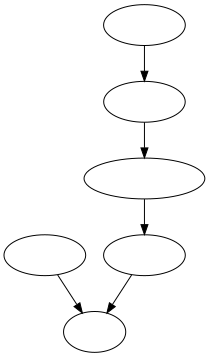

In [23]:
G = Digraph(format='png')
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),5,6):
        for chunk in ls:
            G.node(chunk.phrase())
            if chunk.dst != -1:
                G.edge(chunk.phrase(),ls[chunk.dst].phrase())
G

## 重複回避

In [24]:
def numbering(i,phrase):
    return str(i)+'.'+phrase

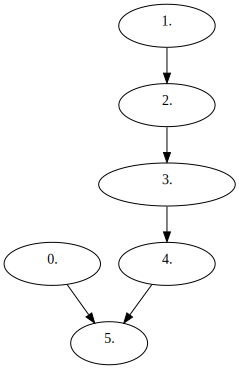

In [25]:
G = Digraph(format='png')
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),5,6):
        for i,chunk in enumerate(ls):
            G.node(numbering(i,chunk.phrase()))
            if chunk.dst != -1:
                G.edge(numbering(i,chunk.phrase()),
                       numbering(chunk.dst,ls[chunk.dst].phrase()))
G

# 45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- ***述語に係る助詞***を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

In [26]:
# 始める  で
# 見る    は を

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

# 疑問点
ここでいう**「述語に係る助詞を格とする」**というのをどこまで厳密にやるのか？？ 
### パターン1 : 助詞を取ってきて、一番右側を「格」とする    
### パターン2 : 一番右側の形態素が助詞の時、それを「格」とする

- 助詞のパターン
    - 一番右が助詞で終わり、述語に係る (パターン1でもパターン2でも抽出可)
        - [...助......**助**]
    - 一番右は助詞ではないが、述語に係る助詞が存在  
    (一番右の助詞が、述語に係ると仮定) (パターン1は抽出可、パターン2で抽出不可)
        - [......助...**助**...]
        - [...助......**助**...]
    - 助詞を含んでいるが、述語に係る助詞は存在しない (パターン1で抽出してしまう)
        - [......助......]

#### パターン1 : 助詞を取ってきて、一番右側を「格」とする

In [27]:
def get_verb_cases(f):
    """動詞とその格(助詞)を取り出す"""
    for ls in read_chunk_cabocha(f):
        for chunk in ls:
            if chunk.contain_pos('動詞'): #文節に”動詞”が含まれていたなら
                
                verb = chunk.get_pos('動詞')[0] #一番左の動詞を述語とする
                cases = [ls[i].get_pos('助詞')[-1] #パターン1
                         for i in chunk.srcs 
                         if ls[i].contain_pos('助詞')]
                
                if len(cases)>0: yield (verb,sorted(cases))

In [28]:
with open(infile_path) as infile:
    with open("src/q045","w") as outfile:
        
        for verb,cases in get_verb_cases(infile):
            case_seq = ' '.join(case for case in cases)
            outfile.writelines(f'{verb}\t{case_seq}\n')

In [29]:
!wc -l src/q045
!echo '\t[動詞]\t[助詞]'
!cat src/q045 | sort | uniq -c | sort -nr | head

20446 src/q045
	[動詞]	[助詞]
    704 云う	と
    452 する	を
    333 思う	と
    202 ある	が
    199 なる	に
    188 する	に
    175 見る	て
    159 する	と
    117 する	が
    113 する	に を
sort: write failed: 'standard output': Broken pipe
sort: write error


#### パターン2 : 一番右側の形態素が助詞の時、それを「格」とする

In [30]:
def get_verb_cases2(f):
    for ls in read_chunk_cabocha(f):
        for chunk in ls:
            if chunk.contain_pos('動詞'): #文節に”動詞”が含まれていたなら
                
                verb = chunk.get_pos('動詞')[0] #一番左の動詞を述語にする
                cases = [ls[i].morphs[-1].base #パターン2
                         for i in chunk.srcs 
                         if ls[i].morphs[-1].pos == '助詞']
                
                if len(cases)>0: yield (verb,cases)

In [31]:
with open(infile_path) as infile:
    with open("src/q045_2","w") as outfile:
        
        for verb,cases in get_verb_cases2(infile):
            case_seq = ' '.join(case for case in cases)
            outfile.writelines(f'{verb}\t{case_seq}\n')

In [32]:
!wc -l src/q045_2
!echo '\t[動詞]\t[助詞]'
!cat src/q045_2 | sort | uniq -c | sort -nr | head

19989 src/q045_2
	[動詞]	[助詞]
    742 云う	と
    537 する	を
    357 思う	と
    241 ある	が
    236 なる	に
    223 する	に
    214 見る	て
    170 する	と
    133 する	が
    105 見る	を
sort: write failed: 'standard output': Broken pipe
sort: write error


## 結果
- パターン1→パターン2で全体の数が減った
    - 20446 -> 19989

    
- パターン1→パターン2でそれぞれの数が増えた
    - 「云う と」 704 -> 742
        - 助詞の組み合わせの数が増減したと予想
        - 「は を」20,「は」5 -> 「は を」15,「は」10
        - 結果を見てみると上位のパターンの頻度が増えていることがわかる
    
    
# 疑問点2
-  [助詞を含む文節] -> [動詞を含む文節] のとき、
- [助詞を含む文節] の一番右の品詞は、助詞以外で何があるのか
- **動詞にかかるくせに最後が助詞で終わらないとは何事**

In [33]:
def test(f,fil):
    """
    係り元の一番右の形態素を取ってくるが、
    フィルターによって取って来れるものを変えられる
    """
    for ls in read_chunk_cabocha(f):
        for chunk in ls:
            if chunk.contain_pos('動詞'): #文節に動詞が含まれているなら
                
                verb = chunk.get_pos('動詞')[0] #一番左側の動詞を述語とする

                cases,pos = [],[]
                for i in chunk.srcs:
                    if fil(ls,i): #フィルターによって取って来るものを調節
                        cases.append(ls[i].surf()) #係り元の全体の文節
                        pos.append(ls[i].morphs[-1].pos) #係り元の、一番右の形態素の品詞
                        
                if len(cases)>0: yield (verb,cases,pos)

### 最初は単純に、動詞にかかる文節の一番右を見てみた。

In [34]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [35]:
%matplotlib inline

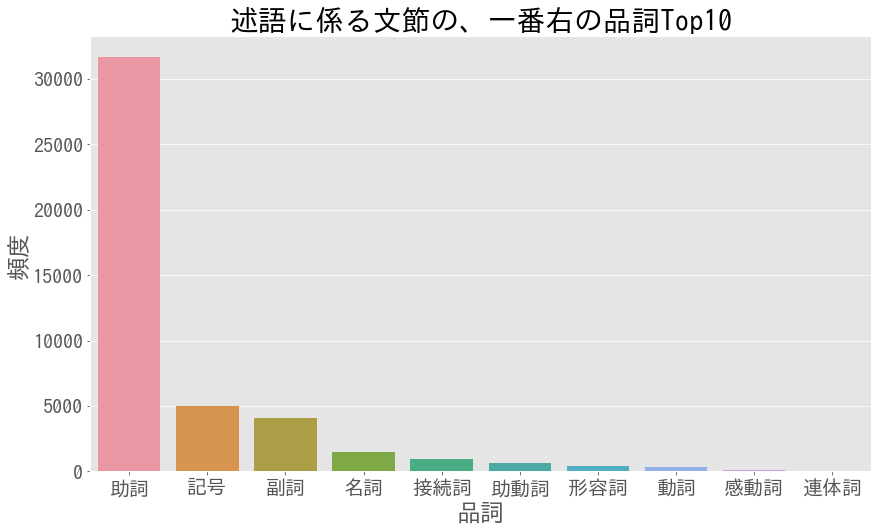

In [36]:
fil = lambda ls,i: True #全てにTrue

with open(infile_path) as f:
    c = Counter(i for verb,cases,pos in test(f,fil) for i in pos)
    
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'TakaoGothic'
    plt.rcParams["font.size"] = 20
    plt.figure(figsize=(14,8))
    plt.title('述語に係る文節の、一番右の品詞Top10')

    df = pd.DataFrame(c.most_common(10),columns=['品詞','頻度'])
    sns.barplot('品詞','頻度',data=df)

### この問題文の意図的に、そもそも助詞が含まれていないといけない。
### 助詞が含まれている文節で比較

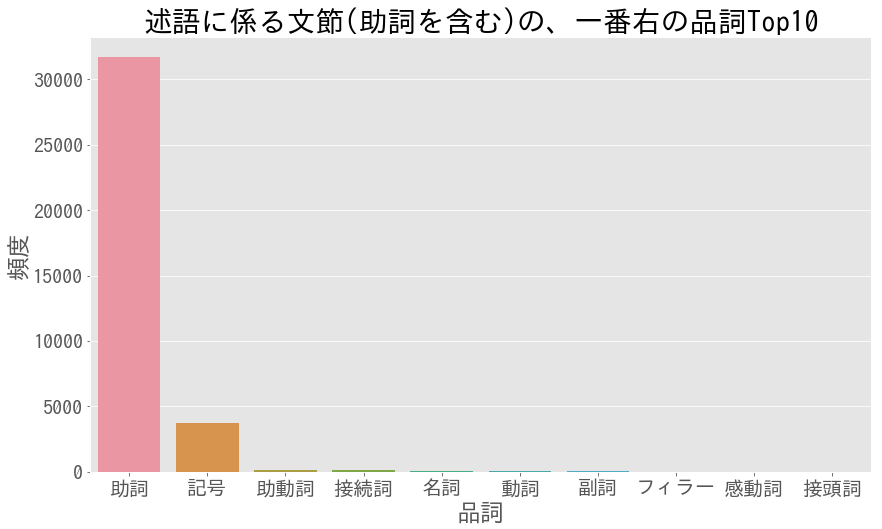

In [37]:
fil = lambda ls,i: ls[i].contain_pos('助詞') #係り元の文節に助詞を含む

with open(infile_path) as f:
    c = Counter(i for verb,cases,pos in test(f,fil) for i in pos)  
    plt.rcParams["font.size"] = 20
    plt.figure(figsize=(14,8))
    plt.title('述語に係る文節(助詞を含む)の、一番右の品詞Top10')   
    df = pd.DataFrame(c.most_common(10),columns=['品詞','頻度'])
    sns.barplot('品詞','頻度',data=df)

### 助詞が圧倒的だが、その他の比較は？？
### 助詞を抜いて可視化

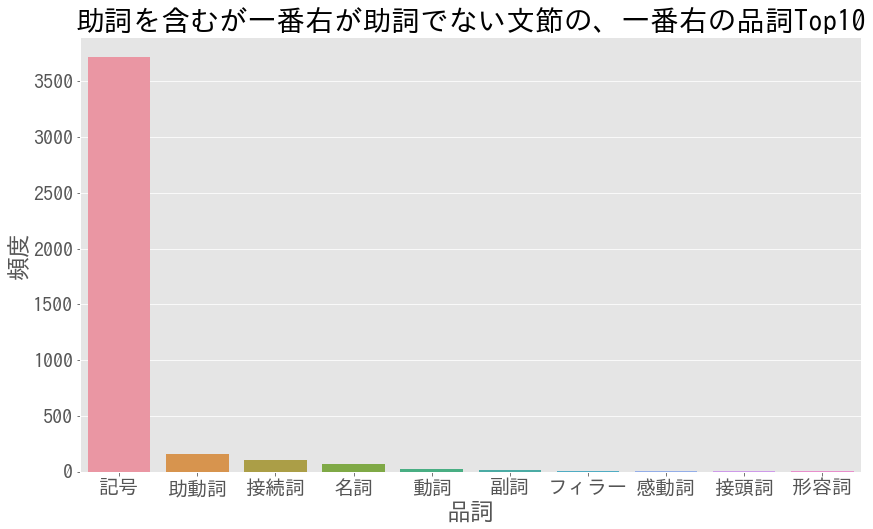

In [38]:
fil = lambda ls,i: (ls[i].contain_pos('助詞') and ls[i].morphs[-1].pos != '助詞') #助詞を含むが一番右が助詞でない

with open(infile_path) as f:
    c = Counter(i for verb,cases,pos in test(f,fil) for i in pos)  
    plt.rcParams["font.size"] = 20
    plt.figure(figsize=(14,8))
    plt.title('助詞を含むが一番右が助詞でない文節の、一番右の品詞Top10')   
    df = pd.DataFrame(c.most_common(10),columns=['品詞','頻度'])
    sns.barplot('品詞','頻度',data=df)

In [39]:
with open(infile_path) as infile:
    with open("src/q045_3","w") as outfile:
        for verb,cases,pos in test(infile,fil):
            case_seq = ' '.join(i for i in cases)
            pos_seq = ' '.join(i for i in pos)
            outfile.writelines(f'{verb}\t{case_seq}\t{pos_seq}\n')

In [40]:
!wc -l src/q045_3
!echo '\t[動詞]\t[文節]\t[一番右の品詞]'
!cat src/q045_3 | sort | uniq -c | sort -nr | head

3552 src/q045_3
	[動詞]	[文節]	[一番右の品詞]
     11 する	して、	記号
      6 する	なって、	記号
      5 見る	思って、	記号
      5 取る	置けば、	記号
      5 する	見ると、	記号
      4 云う	云うから、	記号
      4 する	あって、	記号
      3 する	かくのごとく	助動詞
      3 する	例のごとく	助動詞
      3 食う	食ったり、	記号
sort: write failed: 'standard output': Broken pipe
sort: write error


## 記号が一番右に来る時は、その前が助詞であることが多め。(.........助+記)
## 一番右が助詞でも記号でもないものを抽出

In [41]:
fil = lambda ls,i: ls[i].contain_pos('助詞') and ls[i].morphs[-1].pos != '助詞' and ls[i].morphs[-1].pos != '記号'
# 助詞が含まれているが、一番右が助詞でも記号でもない

In [42]:
with open(infile_path) as infile:
    with open("src/q045_4","w") as outfile:
        for verb,cases,pos in test(infile,fil):
            case_seq = ' '.join(i for i in cases)
            pos_seq = ' '.join(i for i in pos)
            outfile.writelines(f'{verb}\t{case_seq}\t{pos_seq}\n')

In [43]:
!wc src/q045_4
!echo '\t[動詞]\t[文節]\t\t[一番右の品詞]'
!cat src/q045_4 | sort | uniq -c | sort -nr | head

  363  1099 14230 src/q045_4
	[動詞]	[文節]		[一番右の品詞]
      3 する	かくのごとく	助動詞
      3 する	例のごとく	助動詞
      2 要する	吾輩はまた	接続詞
      2 相成る	大兄の如く	助動詞
      2 する	眼玉のごとく	助動詞
      2 出る	例のごとく	助動詞
      2 云う	例のごとく	助動詞
      2 する	主人はまた	接続詞
      1 おひゃらかす	御冗談なんだよ——	名詞
      1 いらっしゃる	「それじゃまた	接続詞


## 助動詞で終わる時は、助詞は述語にかかってなさそう。
## 接続詞で終わるものはそれっぽい...？ということで、接続詞で終わるものを取り出して見た

In [44]:
fil = lambda ls,i: ls[i].contain_pos('助詞') and ls[i].morphs[-1].pos == '接続詞'
# 助詞を含み接続詞で終わる

In [45]:
with open(infile_path) as infile:
    with open("src/q045_5","w") as outfile:
        for verb,cases,pos in test(infile,fil):
            case_seq = ' '.join(i for i in cases)
            outfile.writelines(f'{verb}\t{case_seq}\n')

In [46]:
!wc src/q045_5
!echo '\t[動詞]\t[文節(助詞を含み接続詞で終わる)]'
!cat src/q045_5 | sort | uniq -c | sort -nr | head

 104  208 3187 src/q045_5
	[動詞]	[文節(助詞を含み接続詞で終わる)]
      2 要する	吾輩はまた
      2 する	主人はまた
      1 いらっしゃる	「それじゃまた
      1 引き揚げる	すまして、また
      1 やってくる	妻君がまた
      1 ひねくる	依頼なんでしょう」と、また
      1 あばれる	騒いでいるのか、あるいは
      1 合わせる	我慢するか、または
      1 思い出す	云われるとまた
      1 考え直す	見たが、また


- **推論**
    - 1番右の助詞は述語に係る可能性が高そう
    - [助詞+記号] や [助詞+接続詞] などの助詞も動詞に係る可能性が高そう(?)
    - それ以外(助動詞や名詞など)で終わる文節の助詞は動詞に係らなそう
    
    
- **結論**
    - 厳密に分類することは難しい
    - 動詞にかからない助詞の方が圧倒的に少ない
    - **近似として パターン1 を用いる**

In [47]:
!cat src/q045 | grep -E "^する" | sort | uniq -c | sort -nr | head

    452 する	を
    188 する	に
    159 する	と
    117 する	が
    113 する	に を
     90 する	て を
     85 する	は
     61 する	て
     60 する	が を
     60 する	も


In [48]:
!cat src/q045 | grep "見る" | sort | uniq -c | sort -nr | head

    175 見る	て
     98 見る	を
     23 見る	て て
     20 見る	から
     17 見る	と
     15 見る	て を
     13 見る	て は
     12 見る	から て
     12 見る	で
      9 見る	に


In [49]:
!cat src/q045 | grep "与える" | sort | uniq -c | sort -nr | head

      4 与える	に を
      2 与える	て に は を
      2 与える	て に を
      1 与える	けれども は を
      1 与える	か として
      1 与える	が て と に は は を
      1 与える	て に に は を
      1 与える	て と は を
      1 与える	は は も
      1 与える	で に を


# 46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

In [50]:
# 始める  で      ここで
# 見る    は を   吾輩は ものを

In [51]:
def get_cases_phrases(ls,srcs,exc_index=-2):#exc_index は 47~ で使用
    """格とその文節を取り出す"""
    cases,phrases = [],[]
    for i in srcs:
        if ls[i].contain_pos('助詞') and i != exc_index: #文節に助詞が含まれていて、(特定の文節でないなら)
            
            cases.append(ls[i].get_pos('助詞')[-1]) #助詞の一番右を取り出す
            phrases.append(ls[i].phrase()) #文節を取り出す
#     ソート
    if len(cases) > 0:        
        pair = [(case, phrase) for case, phrase in zip(cases, phrases)]
        sorted_pair = sorted(pair)
        cases, phrases = zip(*sorted_pair)
    
    return (cases,phrases)

In [52]:
def get_verb_cases_phrases(f):
    """動詞、格、文節を取り出す"""
    for ls in read_chunk_cabocha(f):
        for chunk in ls:
            if chunk.contain_pos('動詞'): #文節に動詞があったら
                
                verb = chunk.get_pos('動詞')[0] #一番左の動詞を述語とする
                cases,phrases = get_cases_phrases(ls,chunk.srcs) #格とその文節を取り出す
                
                if len(cases)>0: yield (verb,cases,phrases)

In [53]:
with open(infile_path) as infile:
    with open("src/q046","w") as outfile:
        
        for verb,cases,phrases in get_verb_cases_phrases(infile):
            case = ' '.join(i for i in cases)
            phrase = ' '.join(i for i in phrases)
            
            outfile.write(f'{verb}\t{case}\t{phrase}\n')

In [54]:
!head src/q046

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て


# 47. 機能動詞構文のマイニング

動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

In [55]:
# 返事をする      と に は        及ばんさと 手紙に 主人は

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [56]:
from toolz.itertoolz import sliding_window

In [57]:
def get_pred_cases_phrases(f):
    """述語(サ変接続名詞含む)、格、文節を取り出す"""
    for ls in read_chunk_cabocha(f):
        for index,chunk_pair in enumerate(sliding_window(2,ls)):
            l_chunk, r_chunk = chunk_pair[0], chunk_pair[1]

            if len(l_chunk.morphs)>1 \
                and l_chunk.morphs[-2].pos1=='サ変接続' \
                and l_chunk.morphs[-1].base=='を' \
                and r_chunk.contain_pos('動詞'):
                    
                pred = l_chunk.morphs[-2].surface + "を" + r_chunk.get_pos('動詞')[0]
                cases,phrases = get_cases_phrases(ls,r_chunk.srcs,index) #サ変接続名詞の部分を抽出しないように工夫
                
                if len(cases)>0: yield (pred,cases,phrases)

In [58]:
with open(infile_path) as infile:
    with open("src/q047","w") as outfile:
        
        for pred,cases,phrases in get_pred_cases_phrases(infile):
            case = ' '.join(i for i in cases)
            phrase = ' '.join(i for i in phrases)
            
            outfile.write(f'{pred}\t{case}\t{phrase}\n')

### check

In [59]:
!head src/q047

決心をする	と	こうと
返報をする	んで	偸んで
昼寝をする	が	彼が
迫害を加える	て	追い廻して
生活をする	が を	我等猫族が 愛を
投書をする	て へ	やって ほととぎすへ
話をする	に	時に
昼寝をする	て	出て
欠伸をする	から て て	なったから して 押し出して
御馳走を食う	と	見ると


### コーパス中で頻出する述語（サ変接続名詞+を+動詞）

In [60]:
!wc -l src/q047
!cat src/q047 | cut -f1 | sort | uniq -c | sort -nr | head

488 src/q047
     26 返事をする
     19 挨拶をする
     12 話をする
      8 質問をする
      7 喧嘩をする
      6 真似をする
      5 質問をかける
      5 相談をする
      5 昼寝をする
      4 休養を要する


### コーパス中で頻出する述語と助詞パターン

In [61]:
!wc -l src/q047
!cat src/q047 | cut -f1,2 | sort | uniq -c | sort -nr | head

488 src/q047
      6 返事をする	と
      4 挨拶をする	から
      4 返事をする	と は
      4 挨拶をする	と
      3 質問をかける	と は
      3 喧嘩をする	と
      2 同情を表する	て と は
      2 休養を要する	は
      2 返事をする	から と
      2 挨拶をする	と も


# 48. 名詞から根へのパスの抽出

文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を"->"で連結する

「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

In [62]:
# 吾輩は -> 見た
# ここで -> 始めて -> 人間という -> ものを -> 見た
# 人間という -> ものを -> 見た
# ものを -> 見た

In [63]:
def get_chain_dst(index,ls,phrase_ls):
    if index == -1:
        return phrase_ls
    else:
        phrase_ls.append(index)
        return get_chain_dst(ls[index].dst,ls,phrase_ls)

In [64]:
def noun_to_root(f):
    for ls in itertools.islice(read_chunk_cabocha(f),5,6):
        for i,chunk in enumerate(ls):
            if chunk.contain_pos('名詞'):
                yield ' -> '.join(ls[dst].phrase() for dst in get_chain_dst(i,ls,[]))+'\n'

In [65]:
with open(infile_path) as infile:
    with open("src/q048","w") as outfile:
        for line in noun_to_root(infile):
            outfile.writelines(line)

In [66]:
!head src/q048

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


# 49. 名詞間の係り受けパスの抽出

文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号が$i$と$j$（$i < j$）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"->"で連結して表現する
- 文節$i$と$j$に含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

- 文節$i$から構文木の根に至る経路上に文節$j$が存在する場合: 文節$i$から文節$j$のパスを表示
- 上記以外で，文節$i$と文節$j$から構文木の根に至る経路上で共通の文節$k$で交わる場合: 文節$i$から文節$k$に至る直前のパスと文節$j$から文節$k$に至る直前までのパス，文節$k$の内容を"|"で連結して表示
    
例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

In [75]:
# Xは | Yで -> 始めて -> 人間という -> ものを | 見た
# Xは | Yという -> ものを | 見た
# Xは | Yを | 見た
# Xで -> 始めて -> Y
# Xで -> 始めて -> 人間という -> Y
# Xという -> Y

In [76]:
def xy_phrase(chunk,char): #「ここで」 -> 「Xで」
     return ''.join(char if morph.pos == '名詞' else morph.surface for morph in chunk.morphs)

def is_noun_dstlist(ls,dst_ls): #場合分けに使う
    for i in dst_ls:
        if not ls[i].contain_pos('名詞'): continue
        return True
    return False

def find_co_el(ls1,ls2): #同じ要素を取り出してくる
    for i,el in enumerate(ls1):
        for j,el2 in enumerate(ls2):
            if el == el2: return (i,j,el)

係り受けパスは2パターン

In [77]:
def generator_noun_to_noun(index,ls,dst_ls):
    for i,dst in enumerate(dst_ls):
        if ls[dst].contain_pos('名詞'):
            yield ' -> '.join(itertools.chain([xy_phrase(ls[index],'X')],
                                              (ls[j].phrase() for j in dst_ls[:i]),
                                              'Y'))

In [78]:
def generator_noun_intersec(index,ls,dst_ls):
    for index2,chunk in enumerate(ls[index+1:]):
        if chunk.contain_pos('名詞'):
            dst_ls2 = get_chain_dst(chunk.dst,ls,[])
            
            el = find_co_el(dst_ls, dst_ls2)
            if el:
                phrase1 = ' -> '.join(itertools.chain([xy_phrase(ls[index],'X')],
                                                      (ls[i].phrase() for i in dst_ls[:el[0]])))
                phrase2 = ' -> '.join(itertools.chain([xy_phrase(ls[index2+index+1],'Y')],
                                                      (ls[i].phrase() for i in dst_ls2[:el[1]])))
                phrase3 = ls[el[2]].phrase()
                yield ' | '.join([phrase1,phrase2,phrase3])

結果

In [79]:
def get_dependency_pass(ls):
    for index,chunk in enumerate(ls):
        if chunk.contain_pos('名詞'):
            dst_ls = get_chain_dst(chunk.dst,ls,[])
            if is_noun_dstlist(ls,dst_ls):
                for line in generator_noun_to_noun(index,ls,dst_ls): yield line
            else:
                for line in generator_noun_intersec(index,ls,dst_ls): yield line

In [80]:
with open(infile_path) as f:
    for ls in itertools.islice(read_chunk_cabocha(f),5,6):
        for i in get_dependency_pass(ls):
            print(i)

Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y


In [81]:
%%timeit -r3 -n1
with open(infile_path) as f:
    for ls in read_chunk_cabocha(f):
        for i in get_dependency_pass(ls):
            pass

1.98 s ± 49.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
